In [18]:
import numpy as np
import pandas as pd
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [21]:
df = pd.read_csv('pima-indians-diabetes.csv')
df.head()

,6,148,72,35,0,33.6,0.627,50,1
0,1,85,66,29,0,26.6,0.351,31,0
1,8,183,64,0,0,23.3,0.672,32,1
2,1,89,66,23,94,28.1,0.167,21,0
3,0,137,40,35,168,43.1,2.288,33,1
4,5,116,74,0,0,25.6,0.201,30,0


In [30]:
train, test = train_test_split(df, test_size=0.2)

train = pd.DataFrame.to_numpy(train)
test = pd.DataFrame.to_numpy(test)

xtrain = train[:,:-1]
ytrain = train[:,-1]

xtest = test[:,:-1]
ytest = test[:,-1]

xtrain.shape, ytrain.shape

((613, 8), (613,))

In [178]:
def run_model(xtrain, ytrain, opt, val_data=(None, None), reg=None, epochs=10, mode='val'):

    keras.backend.clear_session()

    input = keras.layers.Input(shape=(8,))

    l1 = keras.layers.Dense(10, activation='relu', use_bias=True,
                            kernel_regularizer=reg)(input)

    l2 = keras.layers.Dense(10, activation='relu', use_bias=True,
                            kernel_regularizer=reg)(l1)

    output = keras.layers.Dense(1, activation='linear', use_bias=True)(l2)

    model = keras.Model(inputs=input, outputs=output)

    model.compile(optimizer=opt, loss=keras.losses.BinaryCrossentropy(from_logits=True), 
                  metrics=[keras.metrics.BinaryAccuracy(name='acc')])

    hist = model.fit(xtrain, ytrain, validation_data=val_data, epochs=epochs, 
                     batch_size=50, verbose=0)

    if mode=='val':
        return hist
    if mode=='test':
        return hist, model

In [115]:
#Loop de validacion y k-folding
epochs = 20
itmax = 10
k_fold = 5
m = xtrain.shape[0]
batch = int(m/k_fold)

for it in range(itmax):
    lambda_ = 10**np.random.uniform(-3, -1)
    lr = 10**np.random.uniform(-4, -1)
    acc = np.zeros((5,), dtype=float)
    val_acc = np.copy(acc)

    reg = keras.regularizers.L2(lambda_)
    opt = keras.optimizers.Adam(lr)
    
    #Loop con mi k-folding criollo
    for k in range(k_fold):
        idx = np.ones((m,))
        idx[k*batch:(k+1)*batch] = 0

        xfold = xtrain[idx==1]
        yfold = ytrain[idx==1]
        xval = xtrain[idx==0]
        yval = ytrain[idx==0]
        
        hist = run_model(xfold, yfold, opt, (xval, yval), reg, epochs)
        acc[k] = hist.history['acc'][-1]
        val_acc[k] = hist.history['val_acc'][-1]
    
    mu = np.mean(acc)
    std = np.std(acc)
    mu_val = np.mean(val_acc)
    std_val = np.std(val_acc)

    print('lr: {:.6f}\t reg: {:.6f}\t train_acc: {:.6f}\t train_std: {:.6f}\t val_acc: {:.6f}\t val_std: {:.6f}\t ({}/{}) '.format(lr, 
           lambda_, mu, std, mu_val, std_val, it+1, itmax))

lr: 0.006838	 reg: 0.024198	 train_acc: 0.712831	 train_std: 0.031683	 val_acc: 0.706557	 val_std: 0.041278	 (1/10) 
lr: 0.067483	 reg: 0.013246	 train_acc: 0.665173	 train_std: 0.012790	 val_acc: 0.667213	 val_std: 0.016878	 (2/10) 
lr: 0.000209	 reg: 0.021410	 train_acc: 0.668432	 train_std: 0.026939	 val_acc: 0.654098	 val_std: 0.015025	 (3/10) 
lr: 0.031780	 reg: 0.047056	 train_acc: 0.663951	 train_std: 0.011376	 val_acc: 0.662295	 val_std: 0.008031	 (4/10) 
lr: 0.043342	 reg: 0.016552	 train_acc: 0.675764	 train_std: 0.018371	 val_acc: 0.678689	 val_std: 0.027627	 (5/10) 
lr: 0.000157	 reg: 0.002078	 train_acc: 0.644807	 train_std: 0.057050	 val_acc: 0.640984	 val_std: 0.050101	 (6/10) 
lr: 0.000396	 reg: 0.002114	 train_acc: 0.680652	 train_std: 0.018143	 val_acc: 0.668852	 val_std: 0.023529	 (7/10) 
lr: 0.000802	 reg: 0.043501	 train_acc: 0.710387	 train_std: 0.017301	 val_acc: 0.695082	 val_std: 0.025607	 (8/10) 
lr: 0.003735	 reg: 0.003298	 train_acc: 0.711609	 train_std: 0.0

In [179]:
#Ahora hago kfold con los hiperparametros buenos
#y corro 200 epocas

reg = keras.regularizers.L2(.003)
opt = keras.optimizers.Adam(.0035)
epochs=500

acc = np.zeros((epochs, 5), dtype=float)
val_acc = np.copy(acc)
#Loop con mi k-folding criollo
for k in range(k_fold):
    idx = np.ones((m,))
    idx[k*batch:(k+1)*batch] = 0

    xfold = xtrain[idx==1]
    yfold = ytrain[idx==1]
    xval = xtrain[idx==0]
    yval = ytrain[idx==0]
        
    hist = run_model(xfold, yfold, opt, (xval, yval), reg, epochs)
    acc[:, k] = hist.history['acc']
    val_acc[:, k] = hist.history['val_acc']

mu = np.mean(acc, axis=1)
std = np.std(acc, axis=1)
mu_val = np.mean(val_acc, axis=1)
std_val = np.std(val_acc, axis=1)

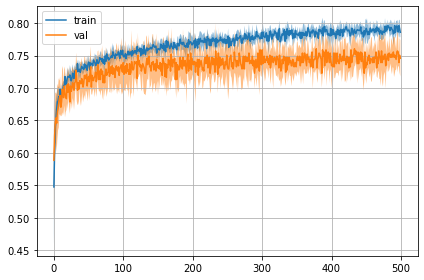

In [180]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
ax1.plot(mu, '-', label='train')
ax1.fill_between(np.arange(epochs), mu - std, mu + std, alpha=0.5)
ax1.grid()

ax1.plot(mu_val, '-', label='val')
ax1.fill_between(np.arange(epochs), mu_val - std_val, mu_val + std_val, alpha=0.5)
ax1.legend(loc='best')

fig.tight_layout()
plt.show()

In [181]:
hist, model = run_model(xtrain, ytrain, opt, (xtest, ytest), reg, epochs=500, mode='test')

In [182]:
preds = model.predict(xtest)
keras.metrics.BinaryAccuracy()(ytest, preds).numpy()

5/5 [==============================] - 0s 7ms/step


0.7467533

In [192]:
idx = 8
plt.scatter(xtrain[:,idx], ytrain)

IndexError: index 8 is out of bounds for axis 1 with size 8